# Deep Learning &mdash; Assignment 9

Assignment for week 9 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will

1. Implement and train a generative adversarial network.
2. Experiment with reverse gradient training.
3. Implement a CycleGAN.
4. Experiment with CycleGAN optimization.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with the [Dive into deep learning](https://d2l.ai) book.
* `PIL`, the python image library

All libraries can be installed with `pip install`.

In [1]:
# render plots as png, not as svg
# (svg is very slow with large scatterplots)
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import csv
import glob
import re
from collections import defaultdict
import numpy as np
import scipy
import sklearn.datasets
import matplotlib.pyplot as plt
import PIL
import torch
import torch.autograd
import torchvision
import torchvision.transforms
from d2l import torch as d2l

from IPython import display

device = d2l.try_gpu()
# device = 'cpu'

# Fix the seed to make the solutions more reproducible
torch.manual_seed(12345);

## 9.1 Moon dataset

The noisy moon dataset is a synthetic dataset with the following distribution:

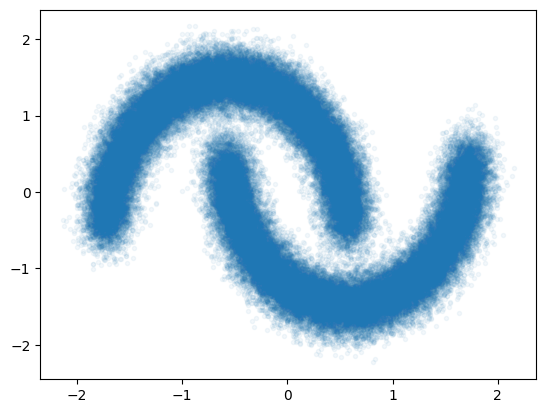

In [2]:
n_samples = 100000
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.1)
noisy_moons[0][:, 0] -= np.mean(noisy_moons[0][:, 0])
noisy_moons[0][:, 0] /= np.std(noisy_moons[0][:, 0])
noisy_moons[0][:, 1] -= np.mean(noisy_moons[0][:, 1])
noisy_moons[0][:, 1] /= np.std(noisy_moons[0][:, 1])
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], '.', alpha=0.05);

**(a) Run the following code to convert the data to a PyTorch dataset:**

In [3]:
moon_dataset = torch.utils.data.TensorDataset(torch.tensor(noisy_moons[0], dtype=torch.float32),
                                              torch.tensor(noisy_moons[1], dtype=torch.float32))

## 9.2 Generator

We define a generator that generates samples from a learned distribution, based on a random noise input.

The generator accepts 1D input vector with 100 elements and has to output a 1D vector with 2 elements.

In [4]:
class MoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.net(x)

**(a) Generate some samples from this generator before training and plot the resulting distribution.**

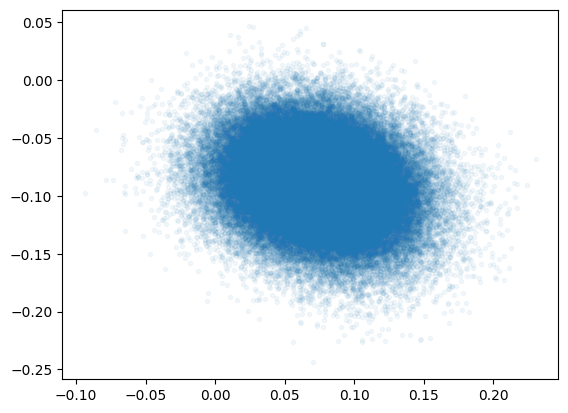

In [5]:
gen = MoonGenerator()
x = torch.rand((n_samples, 100)) * 2 - 1
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.05);

## 9.3 Untrainable dummy generator network

For our experiments, we also define an untrainable dummy generator network that produces samples from a uniform distribution. We'll use this later to investigate what our discriminator learns.

In [6]:
class UniformMoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dummy_param = torch.nn.Parameter(torch.tensor([0.]))

    def forward(self, x):
        return torch.rand((x.shape[0], self.output_size),
                          device=x.device, dtype=x.dtype) * 4 - 2

**(a) Run the code to generate some samples from this generator and plot the resulting distribution.**

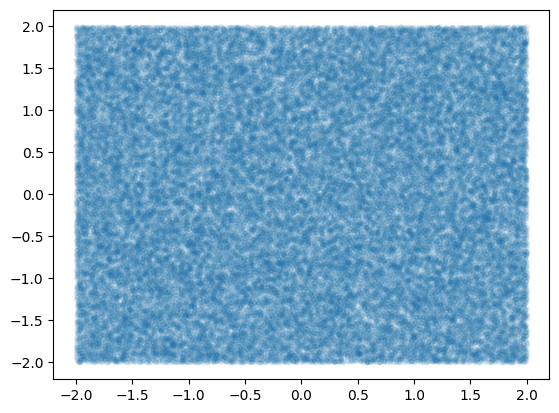

In [7]:
gen = UniformMoonGenerator()
x = torch.randn((n_samples, 100))
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.05);

## 9.4 Discriminator (1 point)

To train the generator, we need a discriminator that takes the samples from the generator and samples from the real distribution. For real samples, the discriminator should predict 1, for fake samples it should predict 0.

For stability, we will exclude the final sigmoid activation from the discriminator and use the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) function during training.

**(a) Inspect the code for the discriminator below:**

In [8]:
class MoonDiscriminator(torch.nn.Module):
    def __init__(self, inputs=2, hiddens=1024):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, 1)
        )
        # Note: Although this is a binary classifier, we do not yet apply
        #       a sigmoid activation here. Instead, we'll use the
        #       BCEWithLogitsLoss later to compute sigmoid + BCE loss in
        #       a numerically stable way.

    def forward(self, x):
        return self.net(x)

We can plot the value of the discriminator in our sample space to see what it is doing.

**(b) Run the code to plot the output of an untrained discriminator:**

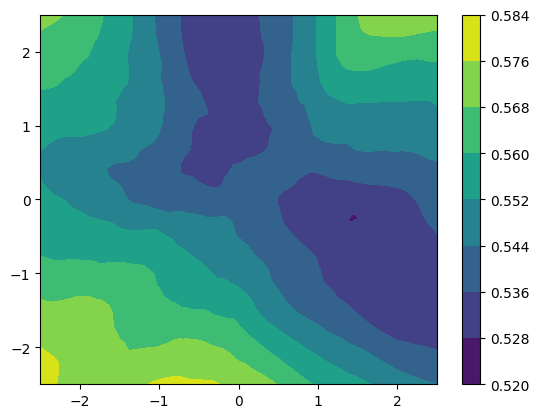

In [9]:
def plot_discriminator(discriminator, xmin=-2.5, xmax=2.5, steps=500, device=device):
    x0, x1 = torch.meshgrid(torch.linspace(xmin, xmax, steps=steps),
                            torch.linspace(xmin, xmax, steps=steps), indexing='ij')
    x = torch.stack([x0.flatten().to(device), x1.flatten().to(device)], axis=1).to(device)
    discriminator = discriminator.to(device)
    y = discriminator(x)
    y = torch.sigmoid(y).detach().cpu().numpy()
    y = y.reshape(x0.shape)
    plt.contourf(x0, x1, y)
    plt.colorbar()

disc = MoonDiscriminator().to(device)
plot_discriminator(disc)

**(c) How should we expect this plot to look after training the discriminator for the moon dataset?<span style="float:right"> (1 point)</span>**

We expect this plot to look similar to the first plot of this assignment; namely that it has a high probability of classifying as real if it is in the shape of the original dataset, and classifying it as fake/generated if it is outside the "two bananas."

## 9.5 Adversarial training loop (1 point)

Now we have a generator and a discriminator, we can attempt to train the model. We will define a training function that implements the adversarial training procedure:

For each minibatch of real samples:
1. Generate a batch of fake samples;
2. Compute the discriminator loss on the real and fake samples;
3. Optimize the discriminator;
4. Generate another batch of fake samples;
5. Compute the generator loss on the fake samples;
6. Update the generator.

To monitor training, we'll print the discriminator and generator loss. We'll also monitor the accuracy of the discriminator (the percentage of correctly labeled real and fake samples) and the 'accuracy' of the generator (the percentage of fake samples incorrectly labeled as real by the discriminator).

**(a) Complete the training loop below:<span style="float:right"> (1 point)</span>**

In [10]:
def train_adversarial(generator, discriminator, data_loader, epochs=10,
                      lr_gen=0.001, lr_disc=0.001, device=device):
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen)
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_disc)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        epoch_disc_acc = 0
        epoch_gen_acc = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            ## 1. Discriminator
            # generate noise for the generator
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            # generate fake samples
            x_fake = generator(rand_for_gen)

            # run discriminator on real and fake samples
            d_real = discriminator(x_real)
            d_fake = discriminator(x_fake)

            # compute discriminator loss
            # - for real samples, the discriminator should predict 1
            # - for fake samples, the discriminator should predict 0
            disc_loss = (bce_logits_loss(d_real, torch.ones_like(d_real)) +
                         bce_logits_loss(d_fake, torch.zeros_like(d_fake)))
            disc_acc = (torch.mean((d_real > 0).to(torch.float)) +
                        torch.mean((d_fake < 0).to(torch.float))) / 2

            # update discriminator
            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()


            ## 2. Generator
            # generate another batch of fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # compute generator loss
            d_fake = discriminator(x_fake)
            # compute the generator loss using d_fake and bce_logits_loss
            #  and the appropriate target value (see the implementation for
            #  the discriminator loss)
            gen_loss = (bce_logits_loss(d_fake, torch.ones_like(d_fake)))
            # for the generator, we compute how many generated samples were given
            # the label 'real' by the discriminator
            gen_acc = torch.mean((d_fake > 0).to(torch.float))

            # update generator
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            ## 3. Statistics
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()
            epoch_disc_acc += disc_acc.item()
            epoch_gen_acc += gen_acc.item()
            mb_count += 1

        print('Epoch %d: disc_loss=%f gen_loss=%f  disc_acc=%f gen_acc=%f' %
              (epoch, epoch_disc_loss / mb_count, epoch_gen_loss / mb_count,
               epoch_disc_acc / mb_count, epoch_gen_acc / mb_count))

## 9.6 Experiment: Train the discriminator only (1 point)

First, we'll train the discriminator only, using the dummy generator to generate samples from a uniform distribution.

**(a) Run the code to train the discriminator:**

In [11]:
gen = UniformMoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

Epoch 0: disc_loss=0.983865 gen_loss=3.010119  disc_acc=0.755325 gen_acc=0.355529
Epoch 1: disc_loss=0.903085 gen_loss=3.611408  disc_acc=0.786760 gen_acc=0.307505
Epoch 2: disc_loss=0.895468 gen_loss=3.681210  disc_acc=0.789592 gen_acc=0.313229
Epoch 3: disc_loss=0.896453 gen_loss=3.787297  disc_acc=0.788698 gen_acc=0.308624
Epoch 4: disc_loss=0.890644 gen_loss=3.830229  disc_acc=0.790616 gen_acc=0.309753
Epoch 5: disc_loss=0.890593 gen_loss=3.908721  disc_acc=0.790706 gen_acc=0.314029
Epoch 6: disc_loss=0.889994 gen_loss=3.952034  disc_acc=0.790956 gen_acc=0.308084
Epoch 7: disc_loss=0.889265 gen_loss=3.955732  disc_acc=0.790881 gen_acc=0.309063
Epoch 8: disc_loss=0.884812 gen_loss=4.028259  disc_acc=0.791820 gen_acc=0.309173
Epoch 9: disc_loss=0.881356 gen_loss=4.044505  disc_acc=0.793948 gen_acc=0.311011


**(b) Plot the discriminator output and inspect the result.**

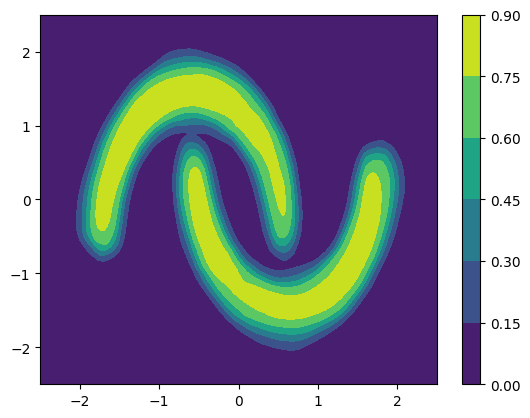

In [12]:
device='cpu'
plot_discriminator(disc, device=device)

**(c) Why does the discriminator not predict 1.00 inside the moons?<span style="float:right"> (1 point)</span>**

Because the generator also produces fakes that are inside the "bananas" and therefore, the discriminator cannot be sure whether it is s real or fake example.

## 9.7 Experiment: Train the generator and discriminator (8 points)

We'll now train the model with the trainable generator.

**(a) Train the generator and discriminator together:**

In [13]:
device= d2l.try_gpu()

gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

Epoch 0: disc_loss=0.956955 gen_loss=1.591298  disc_acc=0.751284 gen_acc=0.223585
Epoch 1: disc_loss=1.262459 gen_loss=0.910806  disc_acc=0.621928 gen_acc=0.318904
Epoch 2: disc_loss=1.346905 gen_loss=0.799984  disc_acc=0.575862 gen_acc=0.368776
Epoch 3: disc_loss=1.361492 gen_loss=0.751063  disc_acc=0.556726 gen_acc=0.389626
Epoch 4: disc_loss=1.369755 gen_loss=0.726828  disc_acc=0.540666 gen_acc=0.405681
Epoch 5: disc_loss=1.377088 gen_loss=0.720000  disc_acc=0.528188 gen_acc=0.405820
Epoch 6: disc_loss=1.316206 gen_loss=0.842427  disc_acc=0.569189 gen_acc=0.365010
Epoch 7: disc_loss=1.265948 gen_loss=0.867515  disc_acc=0.599460 gen_acc=0.324179
Epoch 8: disc_loss=1.376900 gen_loss=0.721050  disc_acc=0.523428 gen_acc=0.428429
Epoch 9: disc_loss=1.384284 gen_loss=0.706227  disc_acc=0.513617 gen_acc=0.477641


**(b) Run the code below to plot the generated samples, the discriminator output, and the real samples.**

**Note:** If you don't get a good results, try to run the model again. This model is quite sensitive to the random initialisation.

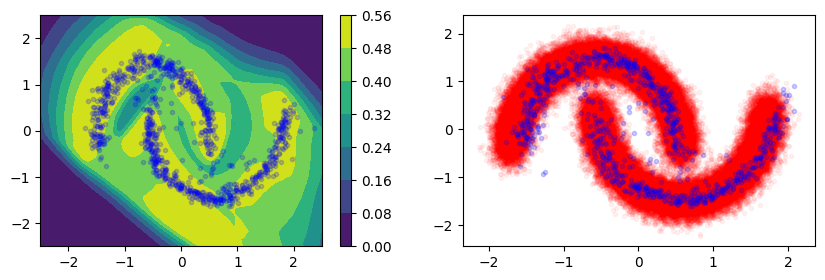

In [14]:
device='cpu'

def plot_generator(generator, n_samples=1000, device=device):
    x = torch.rand((n_samples, 100)).to(device) * 2 - 1
    y = generator(x).detach().cpu().numpy()
    plt.plot(y[:, 0], y[:, 1], 'b.', alpha=0.2)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
disc = disc.to(device)
plot_discriminator(disc, device=device)
gen = gen.to(device)
plot_generator(gen, device=device)
plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.05)
plot_generator(gen)

**(c) Briefly discuss this result.<span style="float:right"> (1 point)</span>**

Running the training multiple times, we had a very different result. The generator and discriminator seem to compete well, and it really depends on the random which is better in reach epoch. If one of the network accuracies is better, the other is worse. This is because, the discriminator has a hard time if the generator gets too good, while the generator does not get proper feedback if the discriminator is too bad.

Compare the output of the new discriminator with the output of the discriminator trained without a generator.

**(d) Are the discriminator outputs the same? Explain why this happens.<span style="float:right"> (1 point)</span>**

No, the discriminators are far from being the same. This is because the discriminator trained with a proper generator has a much harder time discriminating. Therefore, the results are worse.

**(e) Does the discriminator still reach a high accuracy? Why (not?)<span style="float:right"> (1 point)</span>**

No, the discriminator does not reach a high accuracy anymore, because it is basically impossible to distinguish, because the generator generates actually real-looking instances.

**(f) How can we see if the model is working well based on the discriminator accuracy?<span style="float:right"> (2 points)</span>**

If the discriminator has a bad accuracy, this can have two reasons. Either the discriminator is not very good, or the generator is excellent. This means that a low discriminator accuracy is an indication of a good generator model, but not a guarantee.

**(g) Compare the distribution learned by the generator with the real distribution. What are the main differences?<span style="float:right"> (1 point)</span>**

The generated samples highly depend on the individual run, and mostly match the real data. What seems different across multiple runs is that the "bananas are thinner," i.e., the generated samples spread less than the real data.

**(h) Explain the differences you observed above: Why are the generated and real distributions different?<span style="float:right"> (1 point)</span>**

This is because the generators' only goal is to convince the discriminator, which generally has a higher chance of success if the generated data are in the middle of the original ones, compared to be on the edge.

**(i) How can you make the distributions more similar?<span style="float:right"> (1 point)</span>**

One way of fixing the issue is to rebalance how strong the generator is in comparison to the discriminator, for example, by changing the networks' complexity or the size of the mini baches per iteration. Another option is to also optimize for a biggest-possible distance between the individual generated points.

## 9.8 Gradient reversal (5 point)

As an alternative to training the discriminator and generator separately, we can also train the model with a gradient reversal layer that reverses the gradient coming from the discriminator:

```
Forward: generator -> discriminator.
Backward: generator gradient <- gradient reversal <- discriminator gradient.
```

In PyTorch, we'll implement this as a function `revgrad(x)` that will reverse the gradient that passes through it. You can use it like this:
```
y = discriminator(revgrad(generator(x)))
loss = loss_fn(y, target)
loss.backward()
```

**(a) Complete the code to define the `revgrad` gradient reversal function:<span style="float:right"> (1 point)</span>**

In [15]:
class RevGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = input
        return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = (-grad_output)
        return grad_input

revgrad = RevGrad.apply

The training loop is now a bit simpler than before, because we do not have to compute the generator loss separately.

**(b) Complete the new training function:<span style="float:right"> (1 point)</span>**

In [16]:
def train_adversarial_revgrad(generator, discriminator, data_loader, epochs=10, lr=0.001, device=device):
    parameters = list(generator.parameters()) + list(discriminator.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc_real = 0
        epoch_acc_fake = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            # generate fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # run discriminator on real and random samples,
            # reverse the gradient for the generator
            d_real = discriminator(x_real)
            # compute the discriminator output like before,
            # but include the gradient reversal layer
            d_fake = discriminator(revgrad(x_fake))

            # compute loss
            loss_real = bce_logits_loss(d_real, torch.ones_like(d_real))
            loss_fake = bce_logits_loss(d_fake, torch.zeros_like(d_fake))
            loss = loss_real + loss_fake
            
            # compute discriminator accuracy
            acc_real = torch.mean((d_real > 0).to(torch.float))
            acc_fake = torch.mean((d_fake < 0).to(torch.float))

            # update generator and discriminator
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_loss += loss.item()
            epoch_acc_real += acc_real.item()
            epoch_acc_fake += acc_fake.item()
            mb_count += 1

        print('Epoch %d: loss=%f  acc_real=%f acc_fake=%f' %
              (epoch, epoch_loss / mb_count,
               epoch_acc_real / mb_count, epoch_acc_fake / mb_count))

**(c) Train a generator and discriminator with the new training function:**

In [17]:
device=d2l.try_gpu()

gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial_revgrad(gen, disc, loader, epochs=10, lr=0.001, device=device)

Epoch 0: loss=0.974980  acc_real=0.751169 acc_fake=0.751339
Epoch 1: loss=1.210339  acc_real=0.671925 acc_fake=0.635840
Epoch 2: loss=1.326980  acc_real=0.598386 acc_fake=0.555267
Epoch 3: loss=1.362425  acc_real=0.554558 acc_fake=0.540861
Epoch 4: loss=1.385904  acc_real=0.530021 acc_fake=0.503796
Epoch 5: loss=1.387769  acc_real=0.581622 acc_fake=0.439828
Epoch 6: loss=1.354615  acc_real=0.566256 acc_fake=0.540351
Epoch 7: loss=1.255335  acc_real=0.633822 acc_fake=0.603291
Epoch 8: loss=1.364561  acc_real=0.543458 acc_fake=0.531000
Epoch 9: loss=1.383804  acc_real=0.525575 acc_fake=0.508572


**(d) Plot and inspect the results:**

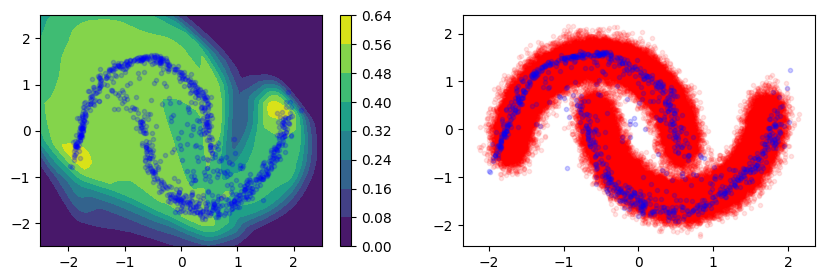

In [18]:
device='cpu'

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
disc = disc.to(device)
plot_discriminator(disc, device=device)
gen = gen.to(device)
plot_generator(gen, device=device)

plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.1)
plot_generator(gen, device=device)

**(e) Briefly discuss the result.<span style="float:right"> (1 point)</span>**

The results look very similar to what we got with the previous approach of calculating the loss.

**(f) What are some advantages and disadvantages of the gradient reversal layer, compared with the previous two-step approach?<span style="float:right"> (2 points)</span>**

One advantage of the reversal layer is that we need less computational power, as we have to compute fewer gradients. One disadvantage can be that the discriminator and generator are tangled together more tightly, which can result in bad feedback loops.

## 9.9 Emoji dataset

For the second part of this assignment we will borrow an emoji dataset (and some ideas) from a course at the [University of Toronto](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/).

The dataset contains images of Apple-style and Windows-style emojis. You can [download the files](http://www.cs.toronto.edu/~jba/emojis.tar.gz) yourself or use the code below.

**(a) Download the dataset and extract the files:**

In [19]:
# !wget -c http://www.cs.toronto.edu/~jba/emojis.tar.gz
# !tar xzf emojis.tar.gz

We'll resize the images to 32 by 32 pixels and normalize the RGB intensities to values between -1 and 1.

**(b) Run the code to construct the datasets:**

In [20]:
import os

def image_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGBA').convert('RGB')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

emoji_path = os.path.join(os.getcwd(), "emojis")

d_windows = torchvision.datasets.ImageFolder(os.path.join(emoji_path, "Windows"), transform, loader=image_loader)
d_apple = torchvision.datasets.ImageFolder(os.path.join(emoji_path, "Apple"), transform, loader=image_loader)

**(c) Plot a few images to see the different styles:**

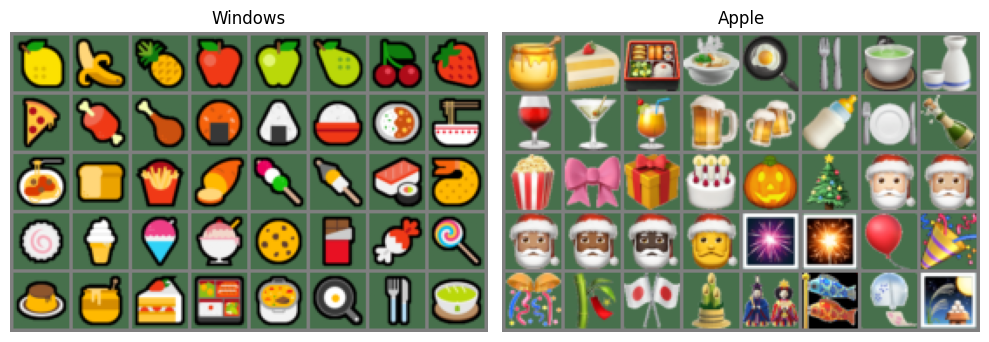

In [21]:
def image_grid(d, idxs):
    images = [d[idx][0] for idx in idxs]
    grid = torchvision.utils.make_grid(images)
    return grid.numpy().transpose(1, 2, 0) / 2 + 0.5

# Depending on the PyTorch version, this code might print
# a warning about transparency. This is not a problem.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_grid(d_windows, range(100, 140)))
plt.title('Windows')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_grid(d_apple, range(400, 440)))
plt.title('Apple')
plt.axis('off')
plt.tight_layout()

## 9.10 CycleGAN (2 points)

We'll try to train a CycleGAN that can translate emojis between the Windows and Apple styles.

This CycleGAN has the following components:
* A generator that translates from Windows to Apple;
* A generator that translates from Apple to Windows;
* A discriminator that discriminates between real and fake emojis from the Windows distribution;
* A discriminator that discriminates between real and fake emojis from the Apple distribution.

### Generator

First, we define the generator. We'll use the same generator architecture for both directions. Unlike before, the generator does not take random noise as input, but expects a 32 by 32 RGB image as input and returns a 32 by 32 RGB image as output.

The generator has the following structure:
```
- Input: 32x32 pixels, 3 channels.
- Two downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 32 -> 64 channels.
- One convolution block in the middle:
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 64 channels.
- Two upsampling + convolution blocks:
  upsampling (scale factor 2) followed by convolution,
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 32 -> 3 channels.
- Output: 32x32 pixels, 3 channels.
```

Add batch normalization and ReLU activations after each convolution, except after the very last layer.

The images have a [-1, +1] range, so the last output should use a tanh activation without BN.

**(a) Complete the code below:<span style="float:right"> (2 points)</span>**

In [22]:
class CycleGenerator(torch.nn.Module):
    def __init__(self, input_size=100):
        super().__init__()
        self.input_size = input_size
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 pixels
            # implement the downsampling part as described above
            torch.nn.Conv2d(3, 32, (5, 5), stride=2, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.Conv2d(32, 64, (5, 5), stride=2, padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),

            # no downsampling, no upsampling
            torch.nn.Conv2d(64, 64, (5, 5), padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            # upsampling 8 -> 16 -> 32 pixels
            # complete the upsampling part as described above
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(64, 32, (5, 5), stride=1, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(32, 3, (5, 5), stride=1, padding=2),
            torch.nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

# the output should have the same shape as the input
assert CycleGenerator()(torch.zeros((30, 3, 32, 32))).shape == torch.Size([30, 3, 32, 32]), "the output should have the same shape as the input"
assert torch.min(CycleGenerator()(torch.zeros((30, 3, 32, 32)))) > -1, "outputs should be in the range [-1,1]"
assert torch.max(CycleGenerator()(torch.zeros((30, 3, 32, 32)))) < 1,  "outputs should be in the range [-1,1]"

### Discriminator

The discriminator is similar in concept to what we had in the GAN model: it takes an image and predicts 1 for a real image and 0 for a fake.

```
- Input: 32x32 pixels, 3 channels.
- Three downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 64 -> 64 -> 64 channels.
- One fully connected layer from (64*4*4) to 1.
- Output: 1 output element.
```

Add batch normalization and ReLU after each convolution, except at the end of the network.

**(b) Read through the code below:**

In [23]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 -> 4
            torch.nn.Conv2d(3, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            
            torch.nn.Linear(64 * 4 * 4, 1)
        )
        # Note: Although this is a binary classifier, we do not apply
        #       a sigmoid activation here. We'll optimize a mean-squared
        #       error to make the discriminator's task a bit harder and
        #       get a slightly better gradient.

    def forward(self, x):
        return self.net(x)

# the output shape should be (30, 1)
assert Discriminator()(torch.zeros((30, 3, 32, 32))).shape == torch.Size([30, 1]), "the output should have shape [30,1]"

## 9.11 CycleGAN training loop (2 points)

The training loop for the GAN with cycle-consistency loss follows the following procedure:

For each batch of samples from domain A and B:
* Use the generators to predict the fake B given A, and fake A given B.
* Use the generators to reconstruct A given fake B, and B given fake A.

The discriminator loss is composed of:
* The discriminator losses for real samples from A and B.
* The discriminator losses for fake samples from A and B.

The cycle-consistency loss is composed of:
* The reconstruction loss comparing the real A with the cycled A->B->A.
* The reconstruction loss comparing the real B with the cycled B->A->B.

Finally, the two groups losses are combined with a weight `lambda_cycle` for the cycle-consistency loss:

```loss = discriminator_loss + lambda_cycle * cycle-consistency loss```

**(a) Complete the code below to implement this procedure:<span style="float:right"> (2 points)</span>**

In [24]:
def train_cycle(generator_ab, generator_ba, discriminator_a, discriminator_b,
                data_loader_a, data_loader_b,
                epochs=10, lr=0.001, lambda_cycle=0.1, device=device):
    mse_loss = torch.nn.MSELoss()
    models = torch.nn.ModuleList([generator_ab, generator_ba, discriminator_a, discriminator_b])
    optimizer = torch.optim.Adam(models.parameters(), lr=lr, betas=(0.5, 0.999))
    
    plt.figure(figsize=(10, 15))

    for epoch in range(epochs):
        epoch_stats = defaultdict(lambda: 0)
        mb_count = 0

        disc_a.train()
        disc_b.train()
        gen_ab.train()
        gen_ba.train()

        for (real_a, _), (real_b, _) in zip(data_loader_a, data_loader_b):
            real_a = real_a.to(device)
            real_b = real_b.to(device)

            # compute fake images A->B->A
            fake_ab = generator_ab(real_a)
            cycle_aba = generator_ba(fake_ab)

            # compute fake images B->A->B
            fake_ba = generator_ba(real_b)
            cycle_bab = generator_ab(fake_ba)

            # run discriminator on real and fake images
            d_real_a = discriminator_a(real_a)
            # compute other discriminator output, use gradient reversal where necessary
            d_real_b = discriminator_b(real_b)
            d_fake_ba = discriminator_a(revgrad(fake_ba))
            d_fake_ab = discriminator_b(revgrad(fake_ab))

            # compute discriminator loss
            # we optimize the MSE loss function to make the gradients of
            # the discriminator a bit easier to use
            loss_real_a = mse_loss(d_real_a, torch.ones_like(d_real_a))
            loss_real_b = mse_loss(d_real_b, torch.ones_like(d_real_b))
            loss_fake_a = mse_loss(d_fake_ba, torch.zeros_like(d_fake_ba))
            loss_fake_b = mse_loss(d_fake_ab, torch.zeros_like(d_fake_ab))

            # compute cycle-consistency loss
            loss_cycle_a = mse_loss(cycle_aba, real_a)
            loss_cycle_b = mse_loss(cycle_bab, real_b)

            # compute loss
            loss = loss_real_a + loss_real_b + \
                   loss_fake_a + loss_fake_b + \
                   lambda_cycle * (loss_cycle_a + loss_cycle_b)

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_stats['loss'] += loss.item()
            epoch_stats['loss_real_a'] += loss_real_a.item()
            epoch_stats['loss_real_b'] += loss_real_b.item()
            epoch_stats['loss_fake_a'] += loss_fake_a.item()
            epoch_stats['loss_fake_b'] += loss_fake_b.item()
            epoch_stats['loss_cycle_a'] += loss_cycle_a.item()
            epoch_stats['loss_cycle_b'] += loss_cycle_b.item()
            mb_count += 1

        if epoch % 5 == 0:
            print('Epoch %d: ' % epoch, end='')
            for k, v in epoch_stats.items():
                print(' %s=%6.4f' % (k, v / mb_count), end='')

            images_for_plot = {
                'real_a': real_a, 'fake_ab': fake_ab, 'cycle_aba': cycle_aba,
                'real_b': real_b, 'fake_ba': fake_ba, 'cycle_bab': cycle_bab,
            }

            for k in range(10):
                for i, (im_title, im) in enumerate(images_for_plot.items()):
                    plt.subplot(10, 6, k * 6 + i + 1)
                    plt.imshow(im[k].detach().cpu().numpy().transpose(1, 2, 0) / 2 + 0.5)
                    if k == 0:
                        plt.title(im_title)
                    plt.axis('off')
            plt.tight_layout()
            display.display(plt.gcf())
            display.clear_output(wait=True)

## 9.12 Experiment: CycleGAN training (6 points)

We can now train our CycleGAN model.

**(a) Run the code below and play with the hyperparameters if necessary to learn a reasonable output.**

Note that GANs can be notoriously difficult to train, so don't worry if your results are not perfect. Hopefully, you will be able to get somewhat recognizable results, but it's more important that you can interpret and discuss what happens.

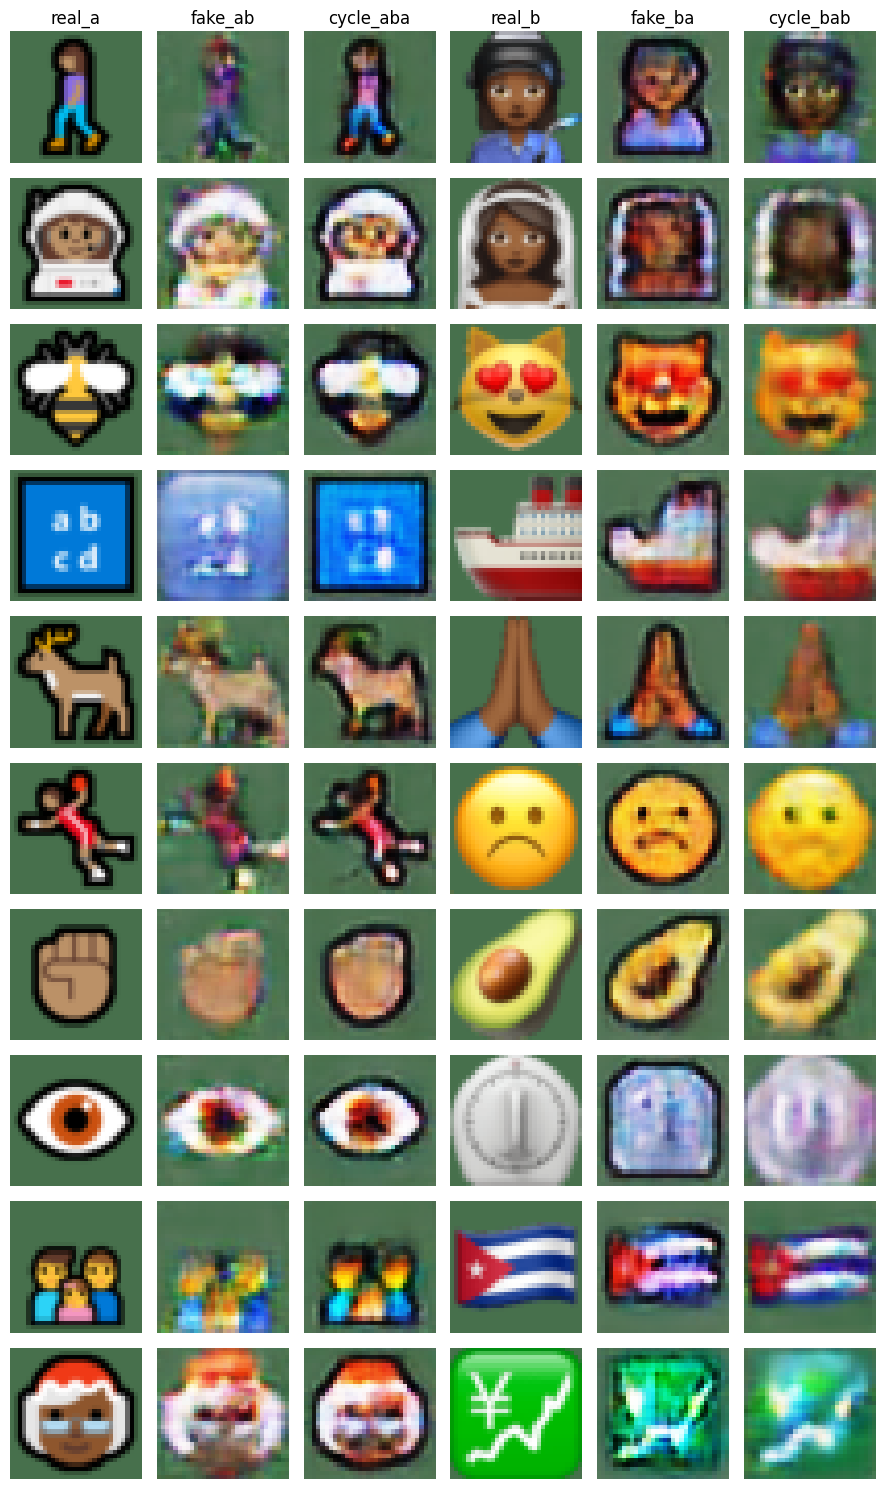

In [25]:
device = d2l.try_gpu()

gen_ab = CycleGenerator().to(device)
gen_ba = CycleGenerator().to(device)
disc_a = Discriminator().to(device)
disc_b = Discriminator().to(device)

loader_a = torch.utils.data.DataLoader(d_windows, batch_size=32, shuffle=True, num_workers=4)
loader_b = torch.utils.data.DataLoader(d_apple, batch_size=32, shuffle=True, num_workers=4)

train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=1, device=device)

**(b) Discuss your results and training experience. Was the model easy to train? What do you think of the results? Does it learn a good translation between Windows and Apple emojis?<span style="float:right"> (2 points)</span>**

Training the model wasn't very easy, as the subjective quality of the results was highly dependent on the specific run and epoch. The end-result does not look very satisfying, but we can clearly see tendencies in the correct direction. For example, the network seems to have learned that Windows emojis have a black outline, while Apples' do not. We can see clear tendencies that the network tries to add/remove those. 

**(c) Run some more experiments to study the effect of the `lambda_cycle` weight.<span style="float:right"> (1 point)</span>**

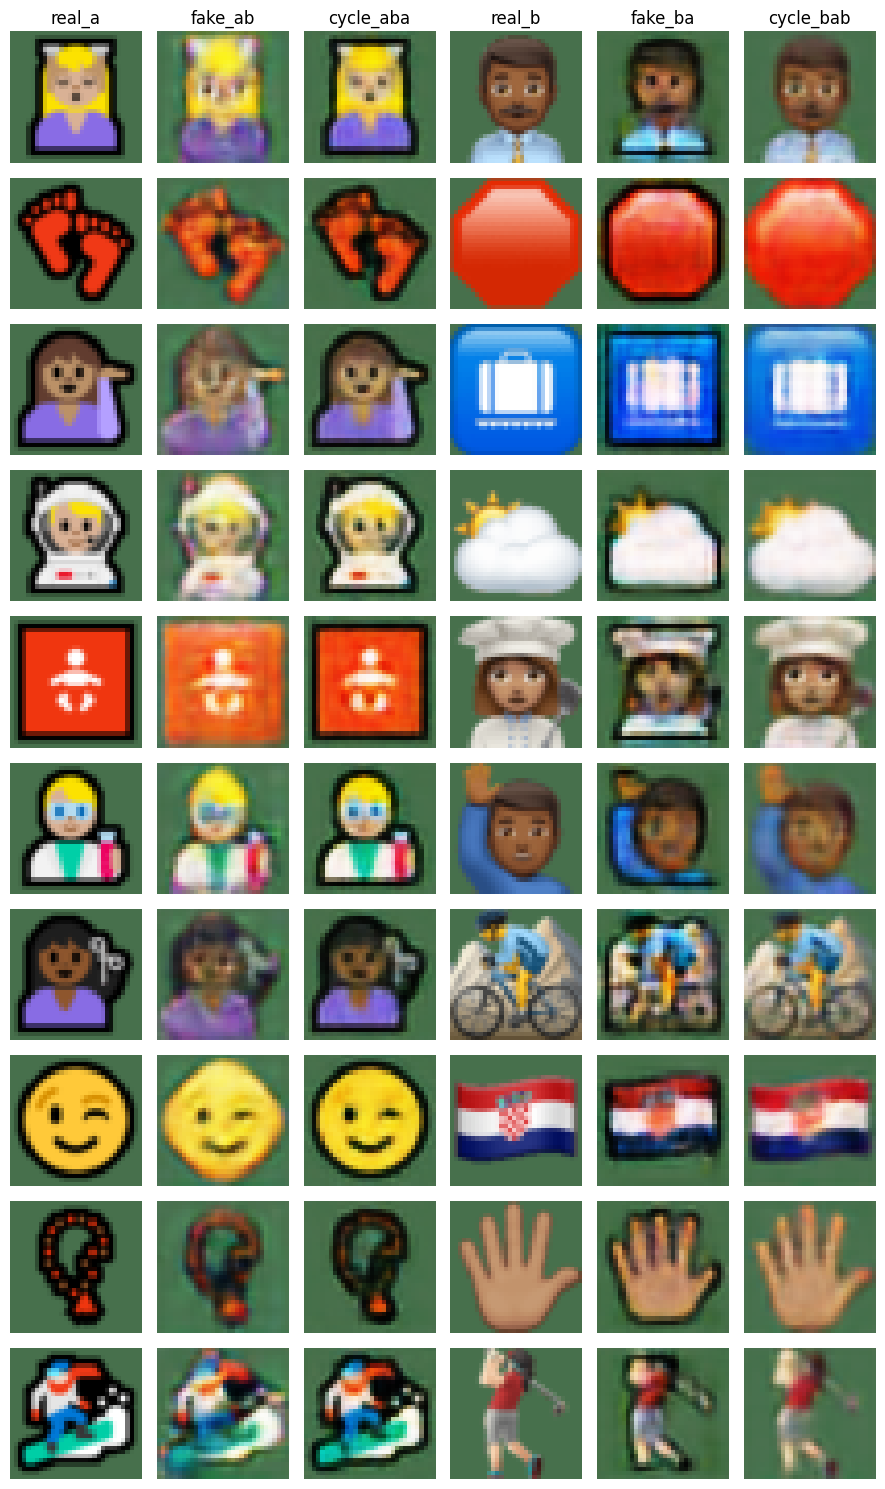

In [26]:
train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=1000, device=device)

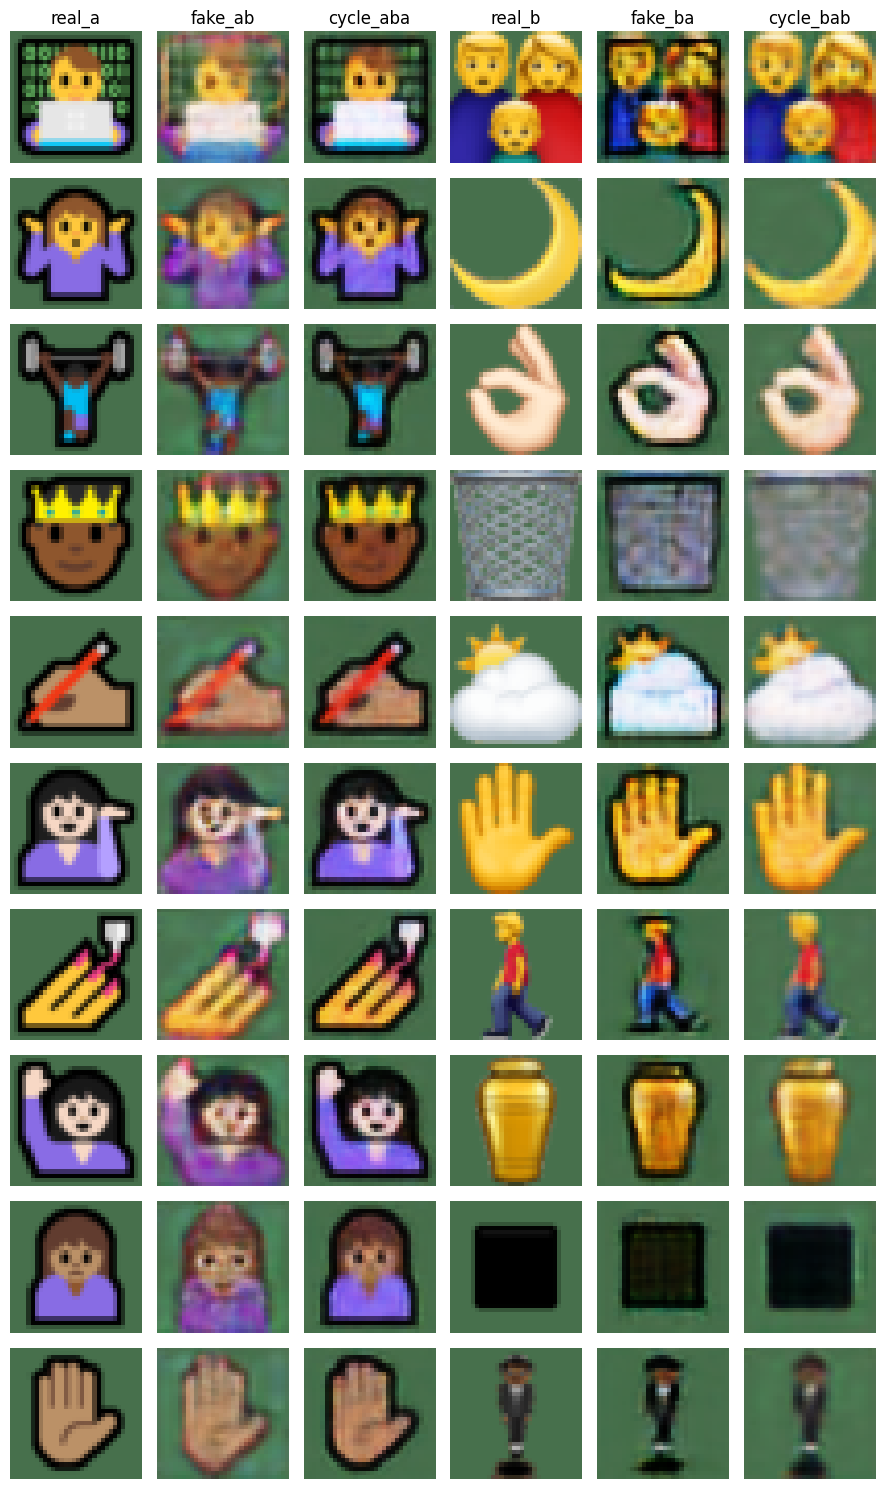

In [27]:
train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=10, device=device)

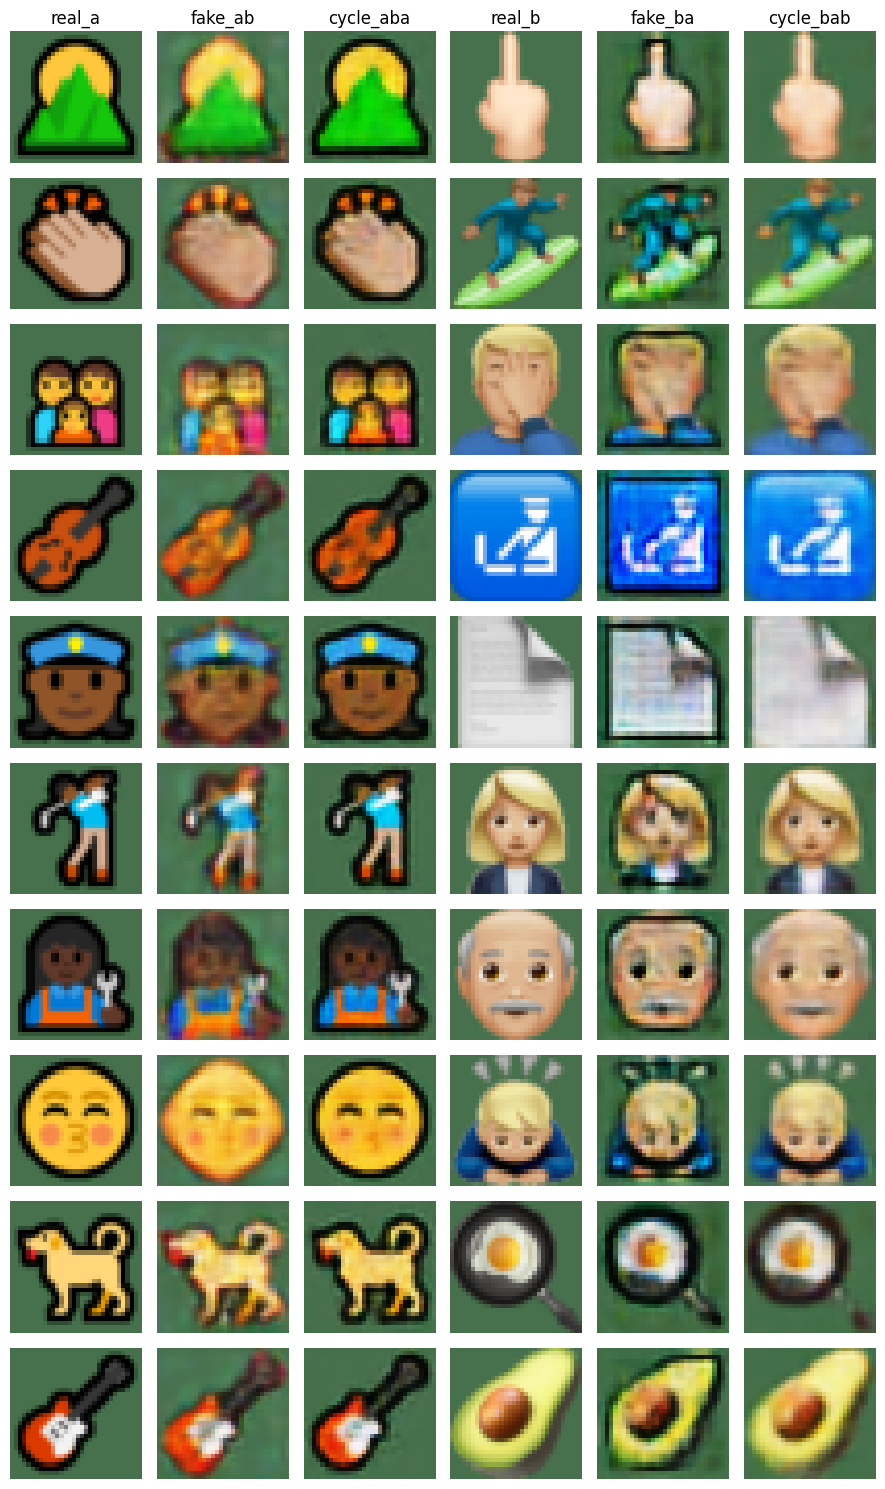

In [28]:
train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=4, device=device)

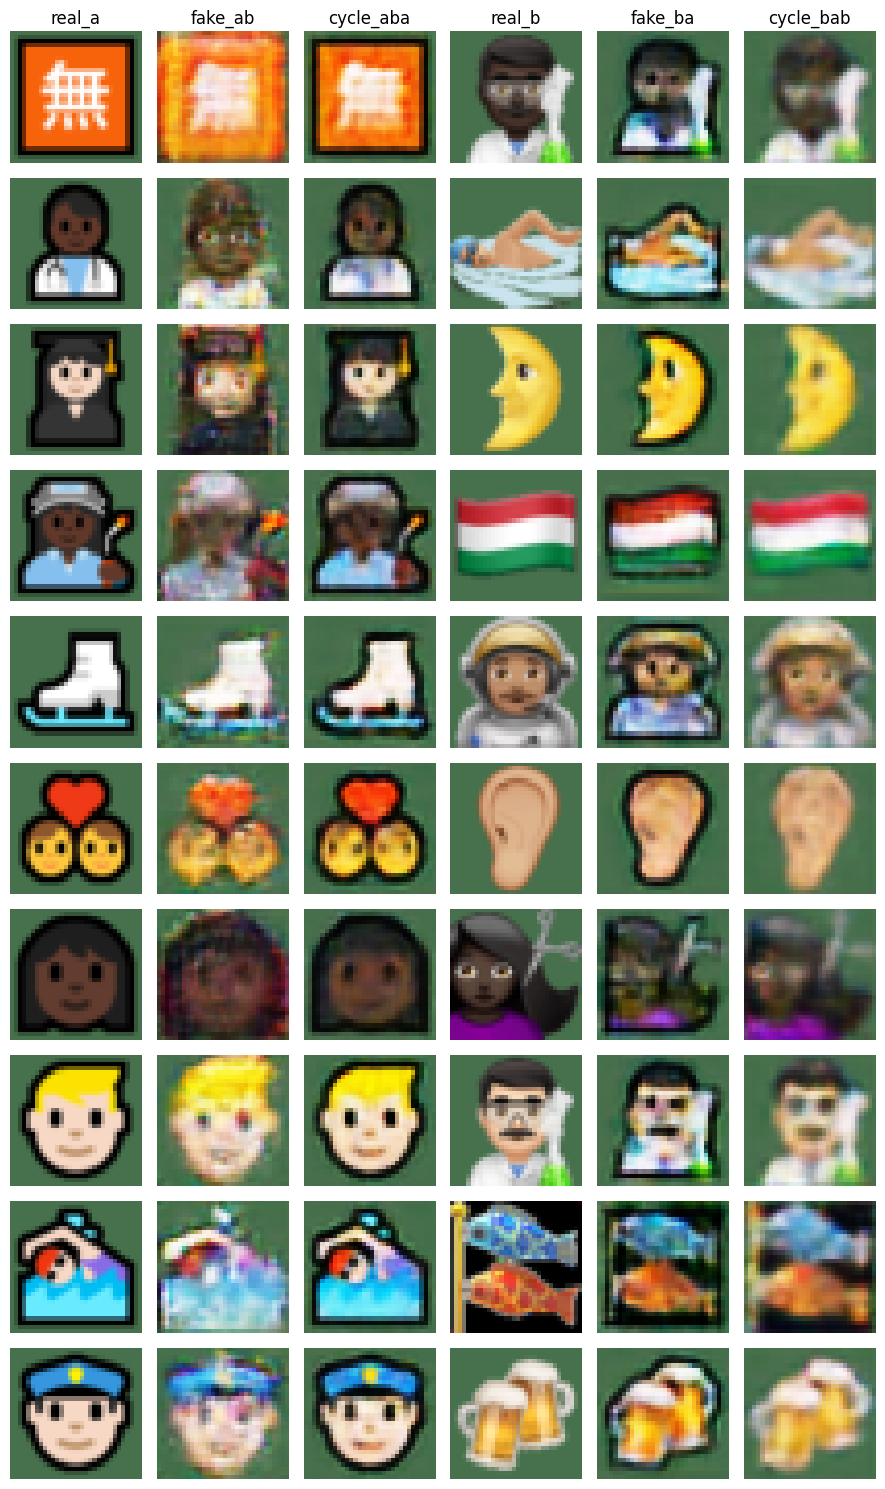

In [29]:
train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=0.5, device=device)

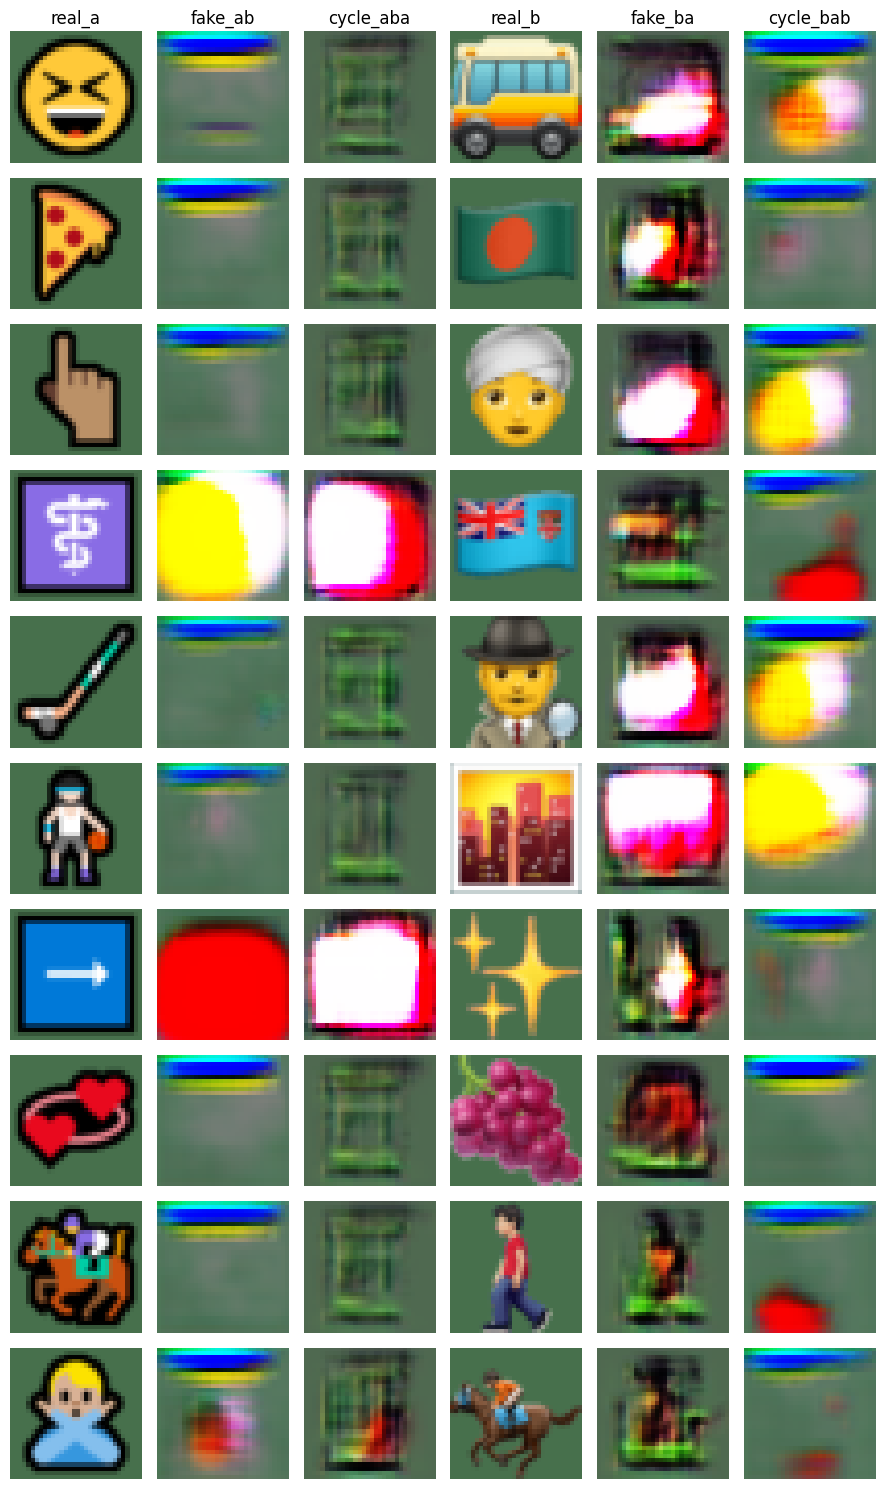

In [30]:
train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=0, device=device)

**(d) What is the effect of the `lambda_cycle` weight? What happens if you set it to a much larger value? What happens if you set it to 0? Can you explain this?<span style="float:right"> (2 points)</span>**

The `lambda_cycle` weight decides how important it is for the network that it can reconstruct the original image from the derived one. Setting this to a high value, i.e., around 4-10 seems to improve the quality of the network. Setting it to zero makes the network perform much worse compared to the default of `lambda_cycle = 1`.
This is because it is important for the reconstruction to create high-quality fakes, as the reconstruction fails otherwise.

On the other hand, if the `lambda_cycle` gets too big, i.e., around `1000`, then the intermediate values just look like the originals, as the accurate reconstruction is weighted much heavier than having a realistic conversion.

**(e) Why is the reconstructed output (A->B->A or B->A->B) usually better than the translated output (A->B or B->A)?<span style="float:right"> (1 point)</span>**

Because it is easier, namely, there is less conversion involved. If the A -> B conversion only made it "half-way" it is relatively easy to recover from there, but the "half-way" result does not look very convincing.

## 9.13 Final questions (4 points)

**(a) Discuss how the balance between the generator and discriminator affects GAN training. What can go wrong if one part is better or learns more quickly than the other?<span style="float:right"> (2 points)</span>**

If one part learns faster than the other, it means that the slower part cannot really learn anything anymore, because the gradients are all close to zero. This happens because, no matter which direction the optimizer would optimize to, it would be bet by the competing network. This problem can be mitigated by balancing the leaning speed by tweaking the batch size or learning rate for each network individually, for example.

**(b) CycleGAN and similar methods are unsupervised models that learn to map inputs from one domain to another. Does this mapping necessarily preserve the semantics of the images? Why, or why not?<span style="float:right"> (1 point)</span>**
<br>(For example, think about how our emoji model would translate flags.)

No, the network does not necessarily preserve the semantics of the image, because the network is only trained to look like *some* image of the other domain, without a specific map of two images between the different domains.
Still, if the images of the two domains are similar enough, we expect no big problems with the mapping. We could also not observe any problems with the mapping of flags for example, though we expect them to be subsceptible to confusion, as they could look simialar to the network in many cases.

**(c) Have a brief look at [CycleGAN, a Master of Steganography](https://arxiv.org/pdf/1712.02950.pdf), a paper published at NIPS 2017. The authors show that a CycleGAN network sometimes 'hides' information in the generated images, to help with the reconstruction. Can you see something like this in your results as well?<span style="float:right"> (1 point)</span>**

Yes, we could observe that with a high `lambda_cycle` value, the color of clothes was not changed anymore, probably to help with reconstruction, but due to the overall bad results and low image resolution we cannot observe any high-frequency encodings.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 30 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version d7aee7b / 2023-11-09</span>